In [28]:
import ee
import geemap

In [29]:
Map = geemap.Map()

In [30]:
ee.Initialize()

In [31]:
from utils.utils import *
from utils.ee_utils import *

In [58]:
# roi = get_square_roi(52.37962731,7.164954376, roi_size=1920, return_gee_object=True)
roi = get_square_roi(53.10515397,13.30088236, roi_size=1920, return_gee_object=True)
Map = geemap.Map(zoom=12)
Map.addLayer(roi)
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [59]:
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.lt('CLOUD_COVER',10)) \
                .filterBounds(roi) \
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8.size().getInfo())
print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))

7
Date: ['2015-04-10', '2015-10-03', '2015-03-25', '2015-09-01', '2015-10-03', '2015-06-04', '2015-10-10']


In [60]:
l8_img = l8.median().clip(roi).multiply(2.75e-05).add(-0.2)
bands = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
l8_img = l8_img.select(bands)

In [61]:
geemap.download_ee_image(l8_img, "l8.tif",crs='EPSG:3857', scale=30,region = roi)

l8.tif: |          | 0.00/629k (raw) [  0.0%] in 00:00 (eta:     ?)

In [62]:
from skimage import io
import numpy as np
l8_np = io.imread('l8.tif')
print(l8_np.shape)
l8_np = correct_image_shape(l8_np)
print(l8_np.shape)
print(np.min(l8_np),np.max(l8_np))

(7, 106, 106)
(106, 106, 7)
-0.0011612500000000026 0.52133875


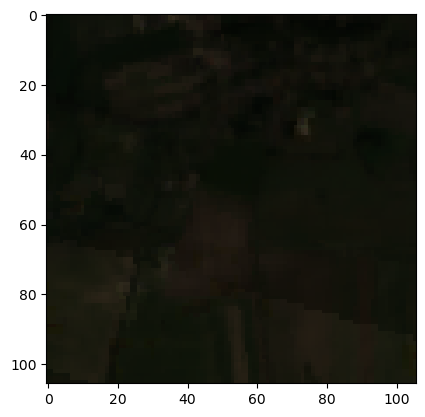

In [63]:
import matplotlib.pyplot as plt
plt.imshow(l8_np[:,:,[3,2,1]])

In [64]:
df = read_csv("LUCAS_2015_Germany.csv")
df

,Piont_id,long,lat
0,40463116,6.072879,51.088722
1,40463188,6.016994,51.734784
2,40523090,6.177697,50.858239
3,40523108,6.164374,51.019789
4,40543118,6.185448,51.110477
...,...,...,...
1681,46543152,14.786924,51.380586
1682,46563124,14.789346,51.128352
1683,46603108,14.831361,50.982524
1684,46623118,14.869216,51.070995


In [168]:
from typing import List
def get_mean_ndvi(image, bands: List[str] = ['SR_B5', 'SR_B4']):
    """
    Returns the mean NDVI of the given image.
    """
    # Compute NDVI
    ndvi = image.normalizedDifference(bands)
    
    # Compute mean of NDVI
    mean_ndvi = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=image.projection().nominalScale(),
        maxPixels=1e13
    ).get('nd')
    
    return mean_ndvi

In [169]:
# applying the Mult and Add function to the image bands but the QABand
def radiometric_correction(image: ee.Image , sr_bands_list = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']):
    """
    Applies radiometric correction to the surface reflectance (SR) bands of an input image, excluding the QA band.

    Args:
        image: An ee.Image object representing the input image.
        sr_bands_list: A list of strings representing the names of the surface reflectance bands to be corrected.

    Returns:
        An ee.Image object with the radiometrically corrected SR bands added as new bands to the input image.
    """
    sr_bands = image.select(sr_bands_list).multiply(2.75e-05).add(-0.2)
    image = image.addBands(sr_bands, None, True)
    return image

In [163]:
# Config
IMAGE_COLLECTION = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
WINTER_RANGES = [('2015-01-01', '2015-02-28'), ('2015-11-01', '2015-12-31')]


In [171]:
winter_ragne_1 = ee.Filter.date(WINTER_RANGES[0][0], WINTER_RANGES[0][1])
winter_range_2 = ee.Filter.date(WINTER_RANGES[1][0], WINTER_RANGES[1][1])
winter_range_filter = ee.Filter.Or(winter_ragne_1, winter_range_2)

for index, row in df.iterrows():
    print(f'Point {row["Piont_id"]}' , end=" -> ")
    loop_roi = get_square_roi(row['lat'],row['long'], roi_size=1920, return_gee_object=True)
    l8 = IMAGE_COLLECTION.filter(winter_range_filter)\
                         .filterBounds(loop_roi).sort('system:time_start')
                         
    #clip the image collection to the roi                     
    l8 = l8.map(lambda img: img.clip(loop_roi))
    
    # Ratiometric correction
    l8 = l8.map(lambda img: radiometric_correction(img))
    
    # add roi cloud cover and cloud shadow property # the index 2 is for the combination of cloud and cloud shadow mask
    l8 = l8.map(lambda img: img.set('roi_cloud_cover', get_mask_ones_ratio(get_cloud_mask(img)[2])))
    
    # add roi snow cover property

    # Add mean_ndvi property
    l8 = l8.map(lambda img: img.set('roi_mean_ndvi', get_mean_ndvi(img)))
    
                         
    
                         
    print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))
    
    # if index == 3:
    #     break

Point 40463116.0 -> Date: ['2015-01-07', '2015-01-16', '2015-01-16', '2015-02-08', '2015-02-24', '2015-11-23', '2015-12-09']
Point 40463188.0 -> Date: ['2015-01-07', '2015-01-16', '2015-02-08', '2015-02-24', '2015-11-23', '2015-12-09']
Point 40523090.0 -> Date: ['2015-01-16', '2015-01-16']
Point 40523108.0 -> 

KeyboardInterrupt: 